# Ch12. 태깅 작업 (Tagging Task)

# v04. 양방향 LSTM을 이용한 품사 태깅 (part-of-speech Tagging using Bi-LSTM)

- 품사 태깅에 대해서는 이미 2챕터의 토큰화 챕터에서 배운 바 있다.
- 그 당시에는 NLTK와 KoNLPy를 이용해서 이미 기존에 있는 모델로 품사 태깅을 수행했다.
- 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델을 만들어본다.

<br>

## 4.1 품사 태깅 데이터에 대한 이해와 전처리

- 이번에는 양방향 LSTM을 이용해서 품사 태깅을 하는 모델을 만들어보자.

<br>

### 4.1.1 필요 패키지 불러오기

In [ ]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

<br>

### 4.1.2 토큰화와 품사 태깅 전처리가 수행된 문장 데이터

- NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있다.
- 여기서는 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어볼 것이다.

- 우선 전체 문장 샘플의 개수를 확인해보자.

In [2]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [3]:
# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()

# 문장 샘플의 개수 출력
print("품사 태깅이 된 문장 개수 : ", len(tagged_sentences))

품사 태깅이 된 문장 개수 :  3914


<br>

- 이 중 첫 번째 샘플만 출력해보자.

In [4]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


- 품사 태깅 전처리가 수행된 첫 번째 문장이 출력된 것을 볼 수 있다.
- 이러한 문장 샘플이 총 3,914개가 있다.

<br>

### 4.1.3 단어와 품사 태깅 정보 분리

- 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 한다.
- 즉, `[('Pierre', 'NNP'), ('Vinken', 'NNP')]`와 같은 문장 샘플이 있다면 `Pierre`과 `Vinken`을 같이 저장하고, `NNP`와 `NNP`를 같이 저장할 필요가 있다.

- 이런 경우 파이썬 함수 중에서 `zip()` 함수가 유용한 역할을 한다.
- `zip()` 함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 한다.  
(2챕터의 데이터의 분리 챕터 참고)

In [ ]:
sentences, pos_tags = [], []

for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.

    # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentence, tag_info = zip(*tagged_sentence)

    # 각 샘플에서 단어 정보만 저장
    sentences.append(list(sentence))

    # 각 샘플에서 품사 태깅 정보만 저장
    pos_tags.append(list(tag_info))

- 각 문장에 샘플에 대해서는 단어는 `sentences`에 저장되고 태깅 정보는 `pos_tags`에 저장했다.

<br>

- 임의로 첫 번째 문장 샘플을 출력해보자.

In [6]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


- 첫 번째 샘플에 대해서 단어에 대해서만 `sentences[0]`에, 또한 품사에 대해서만 `pos_tags[0]`에 저장된 것을 볼 수 있다.
- `sentences`는 예측을 위한 `X`에 해당된다.
- `pos_tags`는 예측 대상인 `y`에 해당된다.

<br>

- 다른 샘플들에 대해서도 처리가 되었는 지 확인하기 위해 임의로 아홉번 째 샘플에 대해서도 확인해보자.

In [7]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


- 단어에 대해서만 `sentences[8]`에, 또한 품사에 대해서만 `pos_tags[8]`에 저장된 것을 확인할 수 있다.

<br>

### 4.1.4 데이터의 길이 분포 확인

- 첫 번째 샘플과 아홉번 째 샘플의 길이가 다른 것을 볼 수 있다.
- 사실 3,914개의 문장 샘플의 길이는 전부 제각각이다.
- 전체 데이터의 길이 분포를 확인해보자.

In [8]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


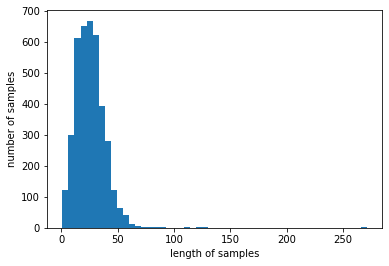

In [9]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 위의 그래프는 대부분의 샘플의 길이가 150 이내이며, 대부분 0~50의 길이를 가지는 것을 보여준다.
- 이제 케라스 토크나이저를 통해서 정수 인코딩을 진행한다.

<br>

### 4.1.5 토큰화

- 우선 케라스 토크나이저를 다음과 같이 함수로 구현한다.

In [ ]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

<br>

- 문장 데이터에 대해서는 `src_tokenizer`를, 레이블에 해당되는 품사 태깅 정보에 대해서는 `tar_tokenizer`를 사용한다.

In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

<br>

- 단어 집합과 품사 태깅 정보 집합의 크기를 확인해보자.

In [12]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


<br>

### 4.1.6 정수 인코딩

In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

- 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 `X_train`에 저장되었다.
- 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 `y_train`에 저장되었다.

<br>

- 정수 인코딩이 되었는 지 확인을 위해 임의로 세 번째 데이터를 출력해보자.

In [14]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


<br>

### 4.1.7 패딩

- 앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 150 이내이다.
- `X`에 해당되는 데이터 `X_train`의 샘플들과 `y`에 해당되는 데이터 `y_train` 샘플들의 모든 길이를 임의로 150 정도로 맞춰보자.
- 이를 위해서 케라스의 `pad_sequences()`를 사용한다.

In [ ]:
max_len = 150

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

<br>

### 4.1.8 훈련 데이터와 테스트 데이터 분리

- 이제 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리한다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=.2, random_state=777)

<br>

### 4.1.9 레이블 데이터 원-핫 인코딩

- 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행한다.

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

<br>

### 4.1.10 각 데이터의 크기 확인

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


<br>

## 4.2 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

### 4.2.1 필요 패키지 불러오기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding, InputLayer, TimeDistributed
from tensorflow.keras.optimizers import Adam

<br>

### 4.2.2 모델 구성

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

<br>

### 4.2.3 컴파일

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

<br>

### 4.2.4 훈련

In [22]:
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 3s 138ms/step - loss: 0.5733 - accuracy: 0.0582 - val_loss: 0.4946 - val_accuracy: 0.0344
Epoch 2/6
25/25 [==============================] - 1s 50ms/step - loss: 0.4912 - accuracy: 0.0392 - val_loss: 0.4491 - val_accuracy: 0.0574
Epoch 3/6
25/25 [==============================] - 1s 46ms/step - loss: 0.4060 - accuracy: 0.0739 - val_loss: 0.3184 - val_accuracy: 0.0881
Epoch 4/6
25/25 [==============================] - 1s 46ms/step - loss: 0.2575 - accuracy: 0.1051 - val_loss: 0.1885 - val_accuracy: 0.1250
Epoch 5/6
25/25 [==============================] - 1s 46ms/step - loss: 0.1356 - accuracy: 0.1411 - val_loss: 0.0992 - val_accuracy: 0.1473
Epoch 6/6
25/25 [==============================] - 1s 46ms/step - loss: 0.0686 - accuracy: 0.1567 - val_loss: 0.0649 - val_accuracy: 0.1540


<br>

### 4.2.5 평가

In [24]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 0s 10ms/step - loss: 0.0662 - accuracy: 0.1540

 테스트 정확도: 0.1540


<br>

### 4.2.6 특정 테스트 데이터 출력

- 실제로 맞추고 있는 지를 특정 테스트 데이터를 주고 직접 출력해서 확인해보자.
- 우선 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 `index_to_word`와 `index_to_tag`를 만들고 이를 이용하여 실제값과 예측값을 출력한다.

In [ ]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

In [27]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 원-핫 인코딩을 다시 정수 인코딩으로 변경
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
